# Tuning Hyperparameters using Bayesian Search

The Bayesian Search package from https://github.com/fmfn/BayesianOptimization was used. In examples https://github.com/fmfn/BayesianOptimization/tree/master/examples there is a lot of guidance on how to set up the search.

# Step 1: Importing all required functions and importing the data. 

In [1]:
import handle_data
import pandas as pd
import plot_results

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
variable_to_predict = "AvgTimeToGate"

In [12]:
def import_data(not_desired_features = None):
    # Import the data
    data = handle_data.csv_to_dataframe("logfiles.csv")
    
    include_checkin = True
    include_security = True
    include_schengen =  True
    include_babygates =  False

    
    data = handle_data.strategies(data, "check_in_strategies.csv", "security_strategies.csv", include_checkin=include_checkin, include_security=include_security, replace=True)
    
    # Remove outliers from training and val
    data = handle_data.remove_faulty(data, variable_to_predict, 1.5, ["INI", "ADA", "HO", "VAL"])
    
    # Feature engineering
    data["Input"]["TotalPassengers"] = data["Input"]['NumberPaxFlight1'] + data["Input"]['NumberPaxFlight2'] + data["Input"]['NumberPaxFlight3'] + data["Input"]['NumberPaxFlight4'] + data["Input"]['NumberPaxFlight5'] + data["Input"]['NumberPaxFlight6'] + data["Input"]['NumberPaxFlight7']
    mean = data["Input"]["TotalPassengers"] / 7
    # data["Input"]["PassengerVariance"] = 1 / (7 + 1) * ((data["Input"]['NumberPaxFlight1'] - mean)**2 +
    #                                                    (data["Input"]['NumberPaxFlight2'] - mean)**2 +
    #                                                    (data["Input"]['NumberPaxFlight3'] - mean)**2 +
    #                                                    (data["Input"]['NumberPaxFlight4'] - mean)**2 +
    #                                                    (data["Input"]['NumberPaxFlight5'] - mean)**2 +
    #                                                    (data["Input"]['NumberPaxFlight6'] - mean)**2 +
    #                                                    (data["Input"]['NumberPaxFlight7'] - mean)**2)
    # data["Input"]["PassengerStandardDeviation"] = data["Input"]["PassengerVariance"]**0.5
    
    # data["Input"]["PassengerSkewness"] = 1 / ((7 + 1)*data["Input"]["PassengerStandardDeviation"]**3) * ((data["Input"]['NumberPaxFlight1'] - mean)**3 +
    #                                                    (data["Input"]['NumberPaxFlight2'] - mean)**3 +
    #                                                    (data["Input"]['NumberPaxFlight3'] - mean)**3 +
    #                                                    (data["Input"]['NumberPaxFlight4'] - mean)**3 +
    #                                                    (data["Input"]['NumberPaxFlight5'] - mean)**3 +
    #                                                    (data["Input"]['NumberPaxFlight6'] - mean)**3 +
    #                                                    (data["Input"]['NumberPaxFlight7'] - mean)**3)
    
    # These 3 make it worse
    # data["Input"]["TotalPassengersSquared"] = data["Input"]["TotalPassengers"]**2
    # data["Input"]["TotalPassengersRoot"] = data["Input"]["TotalPassengers"]**0.5
    # data["Input"]["GateTimePerPassenger"] = data["Input"]["CallToGateStrategy"] / data["Input"]["TotalPassengers"]
    
    if include_checkin:
        data["Input"]["TotalCheckinCounters"] = data["Input"]["C7200-6300"] + data["Input"]["C6300-5400"] + data["Input"]["C5400-4500"] + data["Input"]['C4500-3600'] + data["Input"]['C3600-2700']
        data["Input"]["CheckinCountersPerPassenger"] = data["Input"]["TotalCheckinCounters"] / data["Input"]["TotalPassengers"]
        
        # data["Input"]["C<6300"] = data["Input"]["C6300-5400"] + data["Input"]["C5400-4500"] + data["Input"]['C4500-3600'] + data["Input"]['C3600-2700']
        # data["Input"]["C<5400"] = data["Input"]["C5400-4500"] + data["Input"]['C4500-3600'] + data["Input"]['C3600-2700']
        # data["Input"]["C<4500"] = data["Input"]['C4500-3600'] + data["Input"]['C3600-2700']
        
        
    if include_security:
        data["Input"]["TotalSecurityLanes"] = 8 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"] + data["Input"]['S9000-10800'] + data["Input"]['S>10800']
        data["Input"]["SecurityLanesPerPassenger"] = data["Input"]["TotalSecurityLanes"] / data["Input"]["TotalPassengers"]
        
        # # 'S<1800', 'S1800-3600', 'S7200-9000', 'S9000-10800', 'S>10800
        # data["Input"]['S<10800'] = 8 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"] + data["Input"]['S9000-10800']
        # data["Input"]['S<9000'] = 8 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"] 
        # data["Input"]['S<7200'] = 4 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"]
        # data["Input"]['S<5400'] = 0 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"]
        # data["Input"]['S<3600'] = 0 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"]
        
        
        # data["Input"]['S<1800pp'] = data["Input"]['S<1800'] / data["Input"]["TotalPassengers"]
        # data["Input"]['S1800-3600pp'] = data["Input"]['S1800-3600'] / data["Input"]["TotalPassengers"]
        # data["Input"]['S7200-9000pp'] = data["Input"]['S7200-9000'] / data["Input"]["TotalPassengers"]
        # data["Input"]['S9000-10800pp'] = data["Input"]['S9000-10800'] / data["Input"]["TotalPassengers"]
        # data["Input"]['S>10800pp'] = data["Input"]['S>10800'] / data["Input"]["TotalPassengers"]
        
    if include_schengen:
        data["Input"]["Schengen Passengers"] = data["Input"]['NumberPaxFlight1'] + data["Input"]['NumberPaxFlight2'] + data["Input"]['NumberPaxFlight5'] + data["Input"]['NumberPaxFlight6'] + data["Input"]['NumberPaxFlight7']
        data["Input"]["Non Schengen Passengers"] = data["Input"]['NumberPaxFlight3'] + data["Input"]['NumberPaxFlight4']
    
    if include_babygates:
        data["Input"]["Passengers in Baby Gates"] = data["Input"]['NumberPaxFlight1'] + data["Input"]['NumberPaxFlight2'] + data["Input"]['NumberPaxFlight7']

        data["Input"]["Paasengers in Not Baby Gates"] =  data["Input"]['NumberPaxFlight3'] + data["Input"]['NumberPaxFlight4'] + data["Input"]['NumberPaxFlight5'] + data["Input"]['NumberPaxFlight6'] 
    
    
    training, val, test = handle_data.split_data(data)
    
    training = handle_data.manipulate_data(training)
    val = handle_data.manipulate_data(val)
    test = handle_data.manipulate_data(test)
    
    if not_desired_features != None:
        training["Input"] = training["Input"].drop(not_desired_features, axis=1)
        val["Input"] = val["Input"].drop(not_desired_features, axis=1)
        test["Input"] = test["Input"].drop(not_desired_features, axis=1)
    

    
    return training, val, test

In [13]:
# not_desired_features = ['NumberPaxFlight6', 'CallToGateStrategy', 'NumberPaxFlight7', 'S<1800', 'TotalCheckinCounters', 'C7200-6300', 'S>10800', 'C4500-3600', 'C6300-5400', 'C3600-2700', 'C5400-4500','NumberPaxFlight5', 'S9000-10800', 'S7200-9000', 'NumberPaxFlight3','NumberPaxFlight1', 'TotalSecurityLanes']
not_desired_features = ['C7200-6300', 'C5400-4500', 'C6300-5400', 'C3600-2700']
not_desired_features = None
training, val, test = import_data(not_desired_features)
print(training["Input"].shape)
n_features = training["Input"].shape[1]
print(n_features)
# print(list(training["Input"]))
# print(training["Input"]["PassengerStandardDeviation"])

[DEBUG] Reading logfiles.csv into dataframe
[DEBUG] Finished reading logfiles.csv into dataframe after 1.0063059329986572 seconds
Input data shape:  (127908, 74)
Shape after removing outliers:  (126796, 74)
(75999, 25)
25


# Step 2: Setting up the objective function and search algorithm.

In rf_model the objective function to maximise is setup. Note the error is multiplied by -1 as the function is maximised but the error has to be minimised.

For integer hyperparameter, the number is rounded to an integer.

In tune_hyperparameters_bayes the searching grid is set up, as well as the bayes searching algorithm. The results of the Bayes search are automatically logged into the "bayes_logs" folder, so it can be re-used later if further searching is required.

In [5]:
def rf_model(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params_rf = {}
    params_rf['n_estimators'] = round(n_estimators)
    params_rf['max_depth'] = round(max_depth)
    params_rf['min_samples_split'] = round(min_samples_split)
    params_rf['min_samples_leaf'] = round(min_samples_leaf)
    params_rf['max_features'] = max_features
    
    params_rf['criterion'] = 'squared_error'
    params_rf['n_jobs'] = 14
    params_rf['bootstrap'] = True
    
    model = RandomForestRegressor(**params_rf, random_state=0)
    model.fit(training["Input"], training["Output"][variable_to_predict])
    y_pred = model.predict(val["Input"])

    mse = mean_squared_error(val["Output"][variable_to_predict], y_pred)
    mae = mean_absolute_error(val["Output"][variable_to_predict], y_pred)
    ratio = np.sqrt(mse) / mae
    return -1 * np.sqrt(mse)

In [6]:
def tune_hyperparamaters_bayes(kappa):
    params = dict()
    params['n_estimators'] = (1,100)
    params['max_depth'] = (1, 500)
    params['min_samples_split'] = (2, 1000)
    params['min_samples_leaf'] = (1, 2000)
    params['max_features'] = (1e-3, 1)
    
    # Create the hyperparameter tuning program
    rf_tuning = BayesianOptimization(rf_model, params, random_state=0, allow_duplicate_points=True)
    # Fit the random search model
    
    acquisition_function = UtilityFunction(kind="ucb", kappa=kappa)
    
    logger = JSONLogger(path="./bayes_logs\\logs.json")
    rf_tuning.subscribe(Events.OPTIMIZATION_STEP, logger)
    rf_tuning.set_gp_params()
    
    return rf_tuning, acquisition_function    

# Step 3: Peforming the search

Init_points are the first m points that are randomly sampled from the search grid to get a starting surrogate model. n_iter are the next n points that are picked by the acquisition function.

In [13]:
tuning, acquisition_function = tune_hyperparamaters_bayes(3)

tuning.maximize(init_points = 50, n_iter= 150, acquisition_function = acquisition_function)

# Step 4: Taking notes of the optimal parameters

In [14]:
params = tuning.max["params"]
rmse = -tuning.max["target"]

# Rounding the final parameters to a whole number
params['n_estimators'] = round(params['n_estimators'])
params['max_depth'] = round(params['max_depth'])
params['min_samples_split'] = round(params['min_samples_split'])
params['min_samples_leaf'] = round(params['min_samples_leaf'])

# Parameters that were predefined
params['criterion'] = 'squared_error'
params['n_jobs'] = 14
params['bootstrap'] = True

print(rmse)
print(params)

98.2518238665437
{'max_depth': 244, 'max_features': 0.27374807898706904, 'min_samples_leaf': 278, 'min_samples_split': 256, 'n_estimators': 99, 'criterion': 'squared_error', 'n_jobs': 14, 'bootstrap': True}


In [5]:
# AvgTimeToGate

# rmse = 95.9816855306608
# search range: 50, 150
# kappa = 0.1
params = {
    'max_depth': 340,
    'max_features': 7,
    'min_samples_leaf': 273,
    'min_samples_split': 287,
    'n_estimators': 37,

    'n_jobs':  14,
    'criterion': 'squared_error',
    'bootstrap': True
}

# Step 5: Analyzing the performance of the model

First we train the model with the desired set of hyperparameters. Next a basic linear regressor is trained to compare it against. Finally residual plots and QQ plots and histograms are constructed to study the residual behaviour.

In [6]:
def train(params):
    model = RandomForestRegressor(**params, random_state=0)
    model.fit(training["Input"], training["Output"][variable_to_predict])
    
    # Training set error
    y_pred_training = model.predict(training["Input"])
    mse = mean_squared_error(training["Output"][variable_to_predict], y_pred_training)
    mae = mean_absolute_error(training["Output"][variable_to_predict], y_pred_training)
    ratio = np.sqrt(mse) / mae
    
    print(f"Trained model\nTraining error: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}")
    
    # Validation set error
    y_pred_val = model.predict(val["Input"])
    mse = mean_squared_error(val["Output"][variable_to_predict], y_pred_val)
    mae = mean_absolute_error(val["Output"][variable_to_predict], y_pred_val)
    ratio = np.sqrt(mse) / mae
    
    print(f"Validation error: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}")
    
    # Test set error
    y_pred_test = model.predict(test["Input"])
    mse = mean_squared_error(test["Output"][variable_to_predict], y_pred_test)
    mae = mean_absolute_error(test["Output"][variable_to_predict], y_pred_test)
    ratio = np.sqrt(mse) / mae
    
    print(f"Test error: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}" )
    
    return model

In [14]:
model = train(params)

# Extracting importance
a = np.array([list(training["Input"]), model.feature_importances_])
df = pd.DataFrame(a.T, columns=['feature', 'importance'])
df = df.astype({'feature':'str', 'importance':'float'})
df = df.sort_values('importance', ascending=False)


df_useless = df.loc[df['importance'] < 0.001]

print(df)
print(list(df_useless['feature']))

Trained model
Training error: rmse: 72.40591598941381, mae: 56.61316774250691, ratio: 1.2789589220433115
Validation error: rmse: 99.56812739912725, mae: 77.72403942895461, ratio: 1.281046740888187
Test error: rmse: 99.0857220281948, mae: 77.69470194847446, ratio: 1.2753214767965315
                        feature  importance
18              TotalPassengers    0.294636
22    SecurityLanesPerPassenger    0.238543
23          Schengen Passengers    0.101336
21           TotalSecurityLanes    0.071749
2              NumberPaxFlight2    0.056706
14                   S1800-3600    0.047254
24      Non Schengen Passengers    0.034508
16                  S9000-10800    0.027878
20  CheckinCountersPerPassenger    0.022490
3              NumberPaxFlight3    0.021995
1              NumberPaxFlight1    0.019523
4              NumberPaxFlight4    0.012275
15                   S7200-9000    0.009437
5              NumberPaxFlight5    0.006632
0            CallToGateStrategy    0.006568
6            

In [15]:
linearmodel = LinearRegression()
linearmodel.fit(training["Input"], training["Output"][variable_to_predict])
y_pred = linearmodel.predict(test["Input"])

rmse = np.sqrt(mean_squared_error(test["Output"][variable_to_predict], y_pred))
mae = mean_absolute_error(test["Output"][variable_to_predict], y_pred)
ratio = rmse / mae

print(f"Linear model test set: rmse: {rmse}, mae: {mae}, ratio: {ratio}" )
print(linearmodel.coef_)
print(linearmodel.feature_names_in_)

Linear model test set: rmse: 82.07385144471412, mae: 65.8651870017603, ratio: 1.2460884904573433
[-2.81046599e+00  5.26778235e+11  5.26778235e+11  7.39282091e+11
  7.39282091e+11  5.26778235e+11  5.26778235e+11  5.26778235e+11
  1.32962265e+10  1.32962265e+10  1.32962266e+10  1.32962266e+10
  1.32962266e+10 -9.24518973e+09 -9.24518990e+09 -2.02276039e+10
  1.27196383e+10 -2.02276038e+10 -5.07245284e+12 -1.32962266e+10
  1.77416757e+04  9.24518966e+09  7.26404772e+04  4.54567461e+12
  4.33317075e+12]
['CallToGateStrategy' 'NumberPaxFlight1' 'NumberPaxFlight2'
 'NumberPaxFlight3' 'NumberPaxFlight4' 'NumberPaxFlight5'
 'NumberPaxFlight6' 'NumberPaxFlight7' 'C7200-6300' 'C6300-5400'
 'C5400-4500' 'C4500-3600' 'C3600-2700' 'S<1800' 'S1800-3600' 'S7200-9000'
 'S9000-10800' 'S>10800' 'TotalPassengers' 'TotalCheckinCounters'
 'CheckinCountersPerPassenger' 'TotalSecurityLanes'
 'SecurityLanesPerPassenger' 'Schengen Passengers'
 'Non Schengen Passengers']


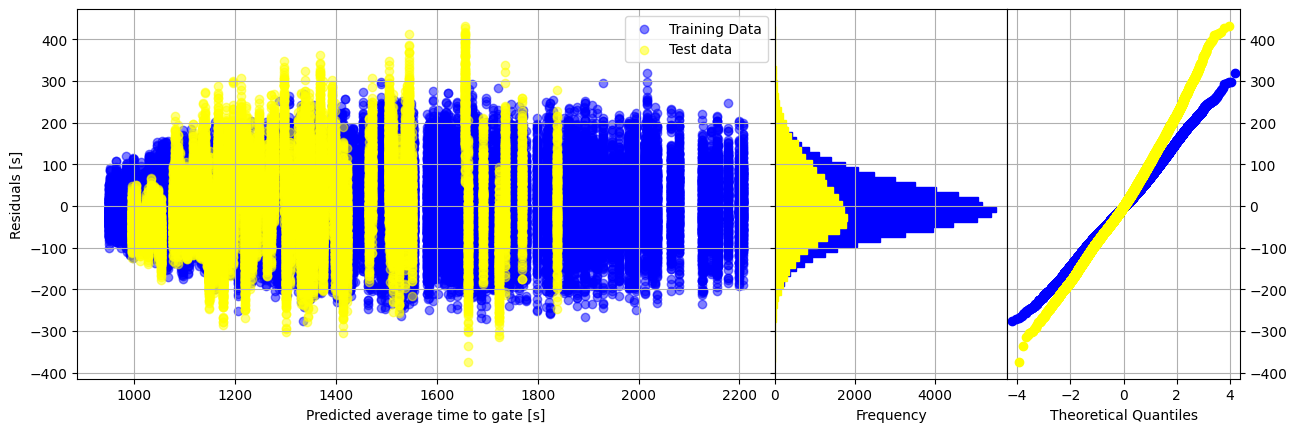

In [16]:
y_pred_train = model.predict(training["Input"]) 
y_pred_test = model.predict(test["Input"]) 

residuals_train = training["Output"][variable_to_predict] - y_pred_train
residuals_test = test["Output"][variable_to_predict] - y_pred_test

plot_results.qq_plot(y_pred_train, y_pred_test, residuals_train, residuals_test, "Predicted average time to gate [s]", "Residuals [s]", 'b', 'yellow')